### 루브릭

평가문항
1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.
    - 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.

2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.
    - 모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.

3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.
    - 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.

### 추상적 요약과 추출적 요약 

In [74]:
! pip install nltk beautifulsoup4

### 1.데이터 수집

In [75]:
#라이브러리 세팅
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /home/aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [76]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [77]:
#데이터 확인
data.head().T

,0,1,2,3,4
headlines,upGrad learner switches to career in ML & Al w...,Delhi techie wins free food from Swiggy for on...,New Zealand end Rohit Sharma-led India's 12-ma...,Aegon life iTerm insurance plan helps customer...,"Have known Hirani for yrs, what if MeToo claim..."
text,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",Kunal Shah's credit card bill payment platform...,New Zealand defeated India by 8 wickets in the...,"With Aegon Life iTerm Insurance plan, customer...",Speaking about the sexual harassment allegatio...


In [78]:
#랜덤 샘플 출력
data.sample(10)

,headlines,text
70083,Apple explains why iPhone X's Face ID failed d...,Apple has said iPhone X's Face ID failed to re...
90274,Jawans get demoralised over negative publicity...,The Delhi High Court has said that when issues...
14374,Peter Higgs won Nobel Prize 49 years after pre...,English physicist Peter Higgs in a 1964 paper ...
62127,I start lots of books but finish few of them: ...,"Microsoft's India-born CEO Satya Nadella, whil..."
85069,"Site promises to track phones, intercept texts...",Online platform Tor Hidden Service offers acce...
63559,New engineering syllabus to include bullet tra...,The All India Council for Technical Education ...
30405,Swedish mom changes son's name after wrong nam...,"Johanna Giselhall Sandstrom, a 30-year-old mot..."
64610,Army plans to deploy women officers for cyber ...,The Indian Army has announced plans to deploy ...
82483,Modi leaves stage with Star Wars' villain them...,PM Narendra Modi left the stage after his spee...
92384,World Bank to give $37.5 cr for National Water...,The World Bank has approved $37.5 crore loan f...


### 2. 데이터 전처리하기 (추상적 요약)

In [79]:
#중복 샘플과 결측치가 있는 샘플 제거
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('text 열에서 중복을 포함한  샘플의 수 :',data['text'].shape)
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('headlines 열에서 중복을 포함한  샘플의 수 :',data['headlines'].shape)
print('전처리 전 전체 샘플수 :',(len(data)))

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
text 열에서 중복을 포함한  샘플의 수 : (98401,)
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
headlines 열에서 중복을 포함한  샘플의 수 : (98401,)
전처리 전 전체 샘플수 : 98401


In [80]:
#중복값 제거
data2 = data.copy()
data2.drop_duplicates(subset = ['text'], inplace = True)
data2.drop_duplicates(subset = ['headlines'], inplace = True)
print('전체 샘플수 :',(len(data2)))

전체 샘플수 : 98262


In [81]:
print(data2.isnull().sum()) #null값 확인

headlines    0
text         0
dtype: int64


### 텍스트 정규화와 불용어 제거


In [82]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [83]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [84]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('done')


done


In [85]:
!  pip install lxml

In [86]:
# 불용어 전처리 함수 테스트
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.


everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


### 전처리 함수 적용

In [87]:
clean_text = []

# 전체 text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data2['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [88]:
clean_headlines = []

# 전체 headlines 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data2['headlines']:
    clean_headlines.append(preprocess_sentence(s))

# 전처리 후 출력
clean_headlines[:5]

['upgrad learner switches career ml al salary hike',
 'delhi techie wins free food swiggy one year cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'known hirani yrs metoo claims true sonam']

In [89]:
# 비어있는 샘플값이 있는지 체크
data2['text'] = clean_text
data2['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data2.replace('', np.nan, inplace=True)
data2.isnull().sum()


headlines    0
text         0
dtype: int64

### 훈련데이터와 테스트데이터 나누기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.10029309397326
기사제목의 최소 길이 : 1
기사제목의 최대 길이 : 13
기사제목의 평균 길이 : 7.136787364393153


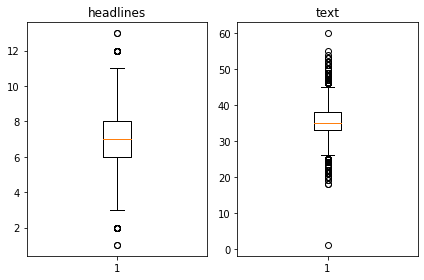

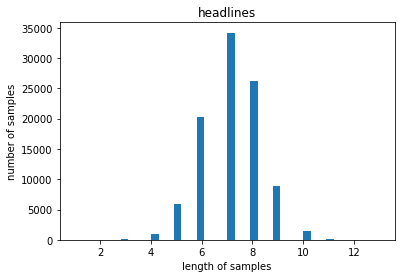

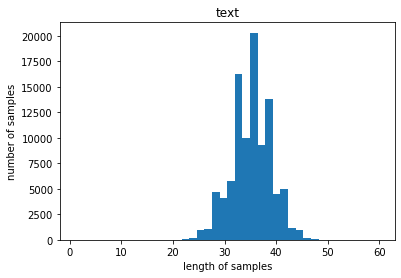

In [90]:
#샘플의 최대 길이 지정하기 위한 분포 시각화
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data2['text']]
headlines_len = [len(s.split()) for s in data2['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('기사제목의 최소 길이 : {}'.format(np.min(headlines_len)))
print('기사제목의 최대 길이 : {}'.format(np.max(headlines_len)))
print('기사제목의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()



In [91]:
text_max_len = 45
headlines_max_len = 8

In [92]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [93]:
below_threshold_len(text_max_len, data2['text'])
below_threshold_len(headlines_max_len,  data2['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967739309193788
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.8925016791842217


In [94]:
#임의로 정한 샘플 길이보다 길면 제외하기 (데이터 정제 )
data3 = data2[data2['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data3 = data2[data2['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :',(len(data3)))

전체 샘플수 : 87699


### 시작 토큰과 종료 토큰 추가하기


In [95]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data3['decoder_input'] = data3['headlines'].apply(lambda x : 'sostoken '+ x)
data3['decoder_target'] = data3['headlines'].apply(lambda x : x + ' eostoken')
data3.head().T

/home/aiffel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/aiffel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,0,4,6,7,9
headlines,upgrad learner switches career ml al salary hike,known hirani yrs metoo claims true sonam,india get lowest odi total new zealand,govt directs alok verma join work day retirement,cong wins ramgarh bypoll rajasthan takes total...
text,saurav kant alumnus upgrad iiit pg program mac...,speaking sexual harassment allegations rajkuma...,india recorded lowest odi total new zealand ge...,weeks ex cbi director alok verma told departme...,congress candidate shafia zubair ramgarh assem...
decoder_input,sostoken upgrad learner switches career ml al ...,sostoken known hirani yrs metoo claims true sonam,sostoken india get lowest odi total new zealand,sostoken govt directs alok verma join work day...,sostoken cong wins ramgarh bypoll rajasthan ta...
decoder_target,upgrad learner switches career ml al salary hi...,known hirani yrs metoo claims true sonam eostoken,india get lowest odi total new zealand eostoken,govt directs alok verma join work day retireme...,cong wins ramgarh bypoll rajasthan takes total...


In [96]:
encoder_input = np.array(data3['text']) # 인코더의 입력
decoder_input = np.array(data3['decoder_input']) # 디코더의 입력
decoder_target = np.array(data3['decoder_target']) # 디코더의 레이블

In [97]:
#직접 코딩하여 훈련데이터 테스트 분리
#encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 생성
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[43210 87598  4807 ... 36374 64843 75316]


In [98]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [99]:
#데이터를 8:2 비율로 훈련/테스트 데이터로 분리
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 17539


In [100]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))


훈련 데이터의 개수 : 70160
훈련 레이블의 개수 : 70160
테스트 데이터의 개수 : 17539
테스트 레이블의 개수 : 17539


### 단어 집합 만들기 및 정수 인코딩

In [101]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [102]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 66034
등장 빈도가 6번 이하인 희귀 단어의 수: 45044
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20990
단어 집합에서 희귀 단어의 비율: 68.21334464063968
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.737717798385882


In [103]:
src_vocab = 20000 
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 20000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [104]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[105, 57, 1, 1156, 1132, 723, 3, 3192, 4107, 105, 48, 753, 3154, 459, 3, 2485, 16568, 428, 1506, 3154, 6395, 48, 3645, 268, 531, 16568, 7348, 753, 2447, 459, 271, 348, 219, 1, 877, 3], [3, 1519, 5733, 2042, 1146, 3476, 11085, 1519, 5733, 2042, 627, 660, 645, 91, 363, 286, 1363, 2198, 35, 45, 883, 168, 5857, 19575, 6643, 6067, 13912, 1180, 5139, 220, 116, 4723, 2757, 1632], [126, 24, 27, 6214, 4724, 139, 4, 15, 538, 309, 7727, 4237, 1, 9396, 1093, 80, 35, 472, 2511, 1647, 222, 240, 1073, 726, 6910, 2212, 4169, 2, 345, 6214, 1127, 443, 1710, 797, 87, 195, 5140]]


In [105]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [106]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28509
등장 빈도가 5번 이하인 희귀 단어의 수: 18851
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9658
단어 집합에서 희귀 단어의 비율: 66.12297870847802
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.537588877969824


In [107]:
tar_vocab = 9500
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 639, 1089, 3, 629, 2753, 2889, 32], [1, 689, 2470, 870, 3, 946, 5321, 519, 701], [1, 1231, 1446, 212, 244, 62, 2623, 2419], [1, 2624, 1899], [1, 5, 274, 77, 89, 3333, 8]]
target
decoder  [[639, 1089, 3, 629, 2753, 2889, 32, 2], [689, 2470, 870, 3, 946, 5321, 519, 701, 2], [1231, 1446, 212, 244, 62, 2623, 2419, 2], [2624, 1899, 2], [5, 274, 77, 89, 3333, 8, 2]]


In [108]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))


삭제할 훈련 데이터의 개수 : 2
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 70158
훈련 레이블의 개수 : 70158
테스트 데이터의 개수 : 17538
테스트 레이블의 개수 : 17538


### 패딩하기

In [109]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

### 기본모델 생성 seq2seq

In [110]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)


### 기본모델의 디코더 설계

In [111]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model= Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 45, 128)      2560000     input_5[0][0]                    
__________________________________________________________________________________________________
lstm_6 (LSTM)                   [(None, 45, 256), (N 394240      embedding_4[0][0]                
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 3. 어텐션 메커니즘 사용하기 (추상적 요약)

In [112]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [113]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 45, 128)      2560000     input_5[0][0]                    
__________________________________________________________________________________________________
lstm_6 (LSTM)                   [(None, 45, 256), (N 394240      embedding_4[0][0]                
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 훈련

In [114]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
275/275 [==============================] - 98s 355ms/step - loss: 6.5349 - val_loss: 6.1945
Epoch 2/50
275/275 [==============================] - 91s 331ms/step - loss: 5.9920 - val_loss: 5.8329
Epoch 3/50
275/275 [==============================] - 92s 336ms/step - loss: 5.6174 - val_loss: 5.5378
Epoch 4/50
275/275 [==============================] - 92s 336ms/step - loss: 5.3386 - val_loss: 5.3344
Epoch 5/50
275/275 [==============================] - 92s 335ms/step - loss: 5.0916 - val_loss: 5.1562
Epoch 6/50
275/275 [==============================] - 94s 342ms/step - loss: 4.8785 - val_loss: 5.0013
Epoch 7/50
275/275 [==============================] - 91s 332ms/step - loss: 4.6966 - val_loss: 4.9041
Epoch 8/50
275/275 [==============================] - 93s 337ms/step - loss: 4.5407 - val_loss: 4.8174
Epoch 9/50
275/275 [==============================] - 92s 334ms/step - loss: 4.4038 - val_loss: 4.7630
Epoch 10/50
275/275 [==============================] - 91s 332ms/step - l

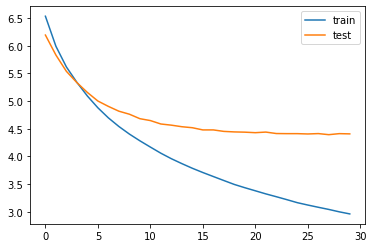

In [116]:
#모델 훈련 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [117]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [119]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [120]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [125]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [126]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp


In [127]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : akshay kumar said entire career based working new directors responding question working new directors risky proposition akshay added action hero years take risks kind action hero akshay worked debutant directors films like jaan mann ishq 
실제 요약 : whole career based working new directors akshay 
예측 요약 :  akshay kumar make akshay kumar


원문 : air pollution europe contributed one india worst affected crore people country according study uk based researchers found india north western regions experienced drop rainfall researchers attributed sulphur emissions industrial areas cause acid rains damaging plant growth 
실제 요약 : pollution europe behind india worst drought study 
예측 요약 :  india pollution hits study


원문 : actor ajay devgn took social media share first look upcoming film baadshaho caption alongside poster read film also stars emraan hashmi ileana cruz vidyut esha gupta directed milan action thriller scheduled release september 
실제 요약 : ajay devgn shares first look baadshaho 
예측

예측 요약 :  man caught camera bomb inside prez


원문 : space shuttle columbia carrying seven crew members including india born astronaut kalpana chawla broke upon earth atmosphere february launch th earth orbiting mission piece foam broke struck left wing entry damaged wing allowed gases penetrate breaking orbiter apart killing crew 
실제 요약 : carrying kalpana chawla crash 
예측 요약 :  astronaut hits km space mission


원문 : us president donald trump wednesday ended policy separating immigrant families us mexico border public uproar like sight feeling families separated trump said children separated family border april may 
실제 요약 : trump ends policy separating families immigrants 
예측 요약 :  trump announces us border migrant


원문 : bjp mp bhushan sharan singh compared congress president rahul gandhi barking dog rahul gandhi slammed pm narendra modi crore pnb scam saying dogs bark elephant keeps walking prime minister modi serving country whoever wants bark bark said 
실제 요약 : bjp mp compares rahul 

예측 요약 :  ias officers transferred transferred assam




### 5. Summa을 이용해서 추출적 요약해보기

In [128]:
! pip install summa

In [149]:
import requests
from summa.summarizer import summarize

In [150]:
data3.text[:1500]

0       saurav kant alumnus upgrad iiit pg program mac...
4       speaking sexual harassment allegations rajkuma...
6       india recorded lowest odi total new zealand ge...
7       weeks ex cbi director alok verma told departme...
9       congress candidate shafia zubair ramgarh assem...
                              ...                        
1891    gujarat chief minister vijay rupani wednesday ...
1892    black american radio host accused white privil...
1893    china expressed strong dissatisfaction canadia...
1894    etihad group ceo tony douglas reportedly offer...
1895    bank unions including india bank officers conf...
Name: text, Length: 1500, dtype: object

In [169]:
test_text = data3.text[:1]
text = test_text.astype(str)
text = text.encode('utf-8')
text

AttributeError: 'Series' object has no attribute 'encode'

In [167]:
#data3.text = data3.text.apply(lambda _: str(_))
#data3.text

/home/aiffel/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


0        saurav kant alumnus upgrad iiit pg program mac...
4        speaking sexual harassment allegations rajkuma...
6        india recorded lowest odi total new zealand ge...
7        weeks ex cbi director alok verma told departme...
9        congress candidate shafia zubair ramgarh assem...
                               ...                        
98395    pakistan started building nearly kilometer fen...
98396    crpf jawan tuesday axed death sharp edged weap...
98397    uff yeh first song sonakshi sinha starrer upco...
98398    according reports new version science fiction ...
98400    madhesi morcha alliance seven political partie...
Name: text, Length: 87699, dtype: object

In [163]:
print('text:')
#print(summarize(data3.text, ratio=0.005))
print(summarize(text, words = 50, ratio=0.005, split=True))
#print(summarize(test_text))

text:


ValueError: Text parameter must be a Unicode object (str)!

### 회고

- 이번 프로젝트에서 **어려웠던 점,**
    - 추상적 요약과 추출적 요약의 장단점을 명확하게 인지하기 어려운점과 인코더와 디코더의 관계는 직관적으로 이해할 수 있으나, 훈련데이터와 테스트데이터를 나누는 방법과 실제와 예측을 비교하는 것을 설명하기 어려운것 같습니다. 
    - summa 사용시 문자열로 기존 데이터 변형이 안되는 점을 해결 하지 못했습니다.
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
    - 언어가 잘 요약되었는지 아닌지, 모델이 잘 학습된것인지 아닌지를 출력된 문장만 보고 판단하기 어려운점이 있습니다. 단지 사람이 읽고 자연스러운지 아닌지를 보고 판단하는것인지 정량적으로 평가하는 지표가 언어생성 영역에서 유의미한지 궁금합니다. 
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
    - 순차적으로 단계별로 풀어서 데이터 전처리와 모델 설계를 진행하였습니다. 
- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
    - 추상적 요약과 추출적 요약의 결과를 비교 분석하고 어떤것이 더 좋은 결과를 생성해 냈는지 설명하기에 모델과 과정에 대한 이해가 다소 부족한것 같습니다.
- **자기 다짐**
    - 언어모델에 대한 이해를 바탕으로 **사람처럼 생각한다는것**은 무엇인가에 대해 좀더 깊이 고민해 보고자 함